# What Does Your Phone Knows About You?
### Travel Mode Detection Using Smartphone Sensors

Every day, we travel with from one place to another on different modes of transportation. Being able to predict the patterns of our citizens' movements using different modes of transport will help urban planning significantly. How can we do so?

That leads me to ask, can we predict what a user is travelling on based on sensors from our phones? Here is an attempt to use accelerometer, gyrometer and linear acceleration sensor data from our smartphones to predict 4 travel modes: Walking, MRT (Train), Bus and Idle. 

In this notebook, I collected data using my phones' sensors and manually labelled the travel mode. Next, I visualized the accelerometer and gyrometer data as a time-series data. The subsequent preprocessing steps include slicing the time series data into sliding windows (thereafter 'journeys'). These journeys are then preprocessed with Fourier Transform to obtain information in the frequency-domain. Simultaneously, mathematical summary statistics are extracted from each of these journeys. Eventually, 1102 features were extracted for each journey, which are decomposed by Principal Component Analysis into 141 features. These PCA features are then fed into a SVC Model that predict with has an F1-score of 82.6%. 

In summary, the following steps were applied:
<img src="Images/BigPicture1.JPG">


# Data Collection

The data is collected using a OnePlus 7 using the app Sensor Kinetics Pro (Android). While collecting the data, the phone is held on hand. 

Overall, over 5 hours of data has been collected for 3 sensors:
* Accelerometer (400Hz)
* Gyrometer (400Hz)
* Linear Acceleration (200Hz)

Each sensor collects data in 3 axes.

This results in 
* ~7,500,000 data points per axis for accelerometer.
* ~7,500,000 data points per axis for gyrometer.
* ~3,500,000 data points per axis for linear acceleration.

# Data Preprocessing

In data preprocessing, the following steps were followed.


<img src="Images/BigPicture.JPG">

### Step 1. Import and Clean Data

In this step, the following are achieved.

1.1. Import all accelerometer data into one large dataframe. (~7 million rows)

1.2. Import all gyrometer data into another large dataframe. (~7 million rows)

1.3. Import all linear acceleration data into another large dataframe. (~3.5 million rows)

1.4. Resample the data (if necessary)

1.5. Apply a sliding window of 2s to accelerometer and gyrometer data with 50% overlap.

1.6. Match the accelerometer and gyrometer sliding windows.

The output is a list of 2s journeys.

### Step 1.1 and 1.2 - Import accelerometer and gyrometer data into two separate dataframes.

In [966]:
import os
import numpy as np
import pandas as pd

    
def read_files():
    mypath = "C:/Users/User/OneDrive - Nanyang Technological University/LTA/Experiment 1/SensorKineticsCharts"
    mypath = os.path.normpath(mypath)
    files = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))] #contains all the files in the directory
    journey_names = []

    for file in files:
        ext = os.path.splitext(file)[-1].lower()
        if ext == ".csv":
            journey_name = os.path.splitext(file)[0].lower().split('_')[0]
            if journey_name not in journey_names:
                journey_names.append(journey_name)
    
    accm_df_list = []
    gyrm_df_list = []
    lacm_df_list = []
    
    for journey_name in journey_names:
        #for accelerometer data
        accm_df = pd.read_csv(os.path.join(mypath, journey_name+ "_accm.csv"),skiprows=[1], 
                            dtype={'time':np.float,
                                   'X_value':np.float, 
                                   'Y_value':np.float,
                                   'Z_value':np.float})
        accm_df['JourneyID'] = journey_name
        if "bus" in journey_name: accm_df['Mode'] = 'Bus'
        if 'mrt' in journey_name: accm_df['Mode'] = 'MRT'
        if 'walk' in journey_name: accm_df['Mode'] = 'Walk'
        if 'idle' in journey_name: accm_df['Mode'] = 'Idle'
        if 'static' in journey_name: accm_df['Mode'] = 'Static'
        accm_df_list.append(accm_df)
        
        #for gyrometer data
        gyrm_df = pd.read_csv(os.path.join(mypath, journey_name+ "_gyrm.csv"),skiprows=[1], 
                            dtype={'time':np.float,
                                   'X_value':np.float, 
                                   'Y_value':np.float,
                                   'Z_value':np.float})
        gyrm_df['JourneyID'] = journey_name
        if "bus" in journey_name: gyrm_df['Mode'] = 'Bus'
        if 'mrt' in journey_name: gyrm_df['Mode'] = 'MRT'
        if 'walk' in journey_name: gyrm_df['Mode'] = 'Walk'
        if 'idle' in journey_name: gyrm_df['Mode'] = 'Idle'
        if 'static' in journey_name: gyrm_df['Mode'] = 'Static'
        gyrm_df_list.append(gyrm_df)
        
        #for linear acceleration data
        gyrm_df = pd.read_csv(os.path.join(mypath, journey_name+ "_lacm.csv"),skiprows=[1], 
                            dtype={'time':np.float,
                                   'X_value':np.float, 
                                   'Y_value':np.float,
                                   'Z_value':np.float})
        gyrm_df['JourneyID'] = journey_name
        if "bus" in journey_name: gyrm_df['Mode'] = 'Bus'
        if 'mrt' in journey_name: gyrm_df['Mode'] = 'MRT'
        if 'walk' in journey_name: gyrm_df['Mode'] = 'Walk'
        if 'idle' in journey_name: gyrm_df['Mode'] = 'Idle'
        if 'static' in journey_name: gyrm_df['Mode'] = 'Static'
        lacm_df_list.append(gyrm_df)
        
        
    all_accm_df = pd.DataFrame(columns = ['time', 'X_value', 'Y_value', 'Z_value', 'JourneyID', 'Mode'])
    all_accm_df = pd.concat(accm_df_list)
    all_accm_df.rename(columns={"X_value": "acc_X", "Y_value": "acc_Y", "Z_value": "acc_Z"}, inplace=True)
    all_accm_df.reset_index(inplace=True,drop=True)
    
    all_gyrm_df = pd.DataFrame(columns = ['time', 'X_value', 'Y_value', 'Z_value', 'JourneyID', 'Mode'])
    all_gyrm_df = pd.concat(gyrm_df_list)
    all_gyrm_df.rename(columns={"X_value": "gyr_X", "Y_value": "gyr_Y", "Z_value": "gyr_Z"}, inplace=True)
    all_gyrm_df.reset_index(inplace=True,drop=True)
    
    all_lacm_df = pd.DataFrame(columns = ['time', 'X_value', 'Y_value', 'Z_value', 'JourneyID', 'Mode'])
    all_lacm_df = pd.concat(gyrm_df_list)
    all_lacm_df.rename(columns={"X_value": "gyr_X", "Y_value": "gyr_Y", "Z_value": "gyr_Z"}, inplace=True)
    all_lacm_df.reset_index(inplace=True,drop=True)

          
    return all_accm_df, all_gyrm_df, all_lacm_df
    #return description, accm_df, grvm_df, gyrm_df, lacm_df, magm_df, rotm_df]
    #suggestion: add in a step that removes the first and final 6 seconds of each unique journey,
    #assuming that the process of starting and ending data collection takes 6 seconds

In [967]:
accm_df, gyrm_df, lacm_df = read_files()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Next, we implement the following the next steps one function `moving_window`. 

1.4. Downsample the data to `target_sampling_rate` from `original_sampling_rate`. (if necessary)

1.5. Apply a sliding window of 2s (`time_per_journey`) to accelerometer and gyrometer data with 50% `overlap`.

1.6. Match the accelerometer and gyrometer sliding windows. 

In [969]:
#https://stackoverflow.com/questions/9542738/python-find-in-list
#https://stackoverflow.com/questions/16243955/numpy-first-occurrence-of-value-greater-than-existing-value
def moving_window(accm_df, gyrm_df, lacm_df, time_per_journey = 2, overlap = 50, original_sampling_rate = 400, target_sampling_rate=400):
    """
    This function takes in two inputs. One dataframe of accelerometer and another accelerometer.
    The accelerometer dataframe should contain the following axis: time, JourneyID, acc_x, acc_y, acc_z.
    The gyrometer dataframe should contain the following axis: time, JourneyID, gyr_x, gyr_y, gyr_z.
    The dataframes should contain at least one continuous journey collected at an acceptable sampling rate.
    The function loops through all the unique continuous journeys of the dataframe for the following functions:
    
    1. In order to downsample the data from the original_sampling_rate to target_sampling_rate,
    the downsampling rate = (original_sampling_rate/target_sampling_rate) is calculated.
    this function slices the data by only selecting every (1 / downsampling_rate)th data.
    For example, if target_sampling_rate = 100 Hz and original_sampling_rate = 400Hz, 
    the downsampling rate is 100/400 = 1/4. Thus, every 4th data point is selected only. 
    
    2. After, a sliding window is applied to the data with a certain precent of overlap.
    In order to implement the sliding window from t=t to t+=time_per_journey,
    this function uses np.searchsorted to find the starting index (idx_start) and ending index (idx_end) 
    for the sliding window. Using a while loop, the sliding window is continued until the data is exhausted.
    Here, the last 6 seconds of each journey is ignored because 
    it is likely that the last 6s of data is not clean.
    
    3. Next, the function checks if there is sufficient data in each sliding window for both
    accelerometer and gyrometer data. If the number of data points in each sliding window is above 
    a threshold (hardcoded to be target_sampling_rate * time_per_journey * 0.875) for both accelerometer 
    and gyrometer data, then the pair [idx_start, idx_end] is simulatenously added to the lists accm_slicers 
    and gyrm_slicers. This simultaneous addition for both accelerometer and gyrometer data is essential in 
    ensuring that that there are equal number of sliding windows for gyrometer and accelerometer data.
    
    The output of the data are 
    accm_slicers - a list of starting and ending indices for each of the accelerometer sliding window.
    accm_df_copy - a downsampled accelerometer dataframe.
    gyrm_slicers - a list of starting and ending indices for each of the gyrometer  sliding window. 
    gyrm_df_copy - a downsampled gyrometer dataframe.
    
    In order to access the ith sliding window of the downsampled accelerometer data, 
    use the function implemented below:
    def get_df_windows(df = accm_df_copy,i):
        slicer = gyrm_slicers[i]
        idx = np.arange(slicer[0], slicer[1])
        return df.iloc[idx,:]
    
    """
    
    #Making calculations
    downsampling_rate =  target_sampling_rate / original_sampling_rate
    data_points_skipped =  int(1 / downsampling_rate)
    time_increment = time_per_journey * overlap // 100 
    threshold = int(target_sampling_rate * time_per_journey * 0.875) 
    #0.875 is set as a constant to ensure so that for a 2s per journey slicing window, 
    #data sets of at least (2s * 0.875 = 1.75s) are added as well instead of discarded.
    
    #Initializing values
    accm_slicers=[]
    gyrm_slicers=[]
    lacm_slicers=[]
    accm_max_index = 0
    gyrm_max_index = 0
    lacm_max_index = 0
    
    #Downsampling accelerometer data
    accm_df_copy = accm_df[0: len(accm_df): data_points_skipped]
    
    #Downsampling gyrometer data
    gyrm_df_copy  = gyrm_df[0: len(gyrm_df): data_points_skipped]
    
    #Downsampling linear acceleration meter data
    lacm_df_copy  = lacm_df #[0: len(gyrm_df): data_points_skipped]
    
    #Iterating through all unique journeys
    unique_journey = accm_df['JourneyID'].unique()
    
    for journey in unique_journey:
        accm_timestamp = accm_df_copy.loc[accm_df['JourneyID']==journey,:]['time']
        gyrm_timestamp  = gyrm_df_copy.loc[gyrm_df['JourneyID']==journey,:]['time']
        lacm_timestamp  = lacm_df_copy.loc[gyrm_df['JourneyID']==journey,:]['time']

        time_max = gyrm_timestamp.max() #or using accm_timestamp.max() would work too
        
        gyrm_timestamp = gyrm_timestamp.values.ravel() #converting time from pd.Series to np array
        accm_timestamp = accm_timestamp.values.ravel() #converting time from pd.Series to np array
        lacm_timestamp = lacm_timestamp.values.ravel() #converting time from pd.Series to np array
        
        t = 0
        
        if time_max > 10: #only use samples that are more than 12 seconds.
            #Implementing sliding window for gyrometer and accelerometer simultaneously.
            while t + 3 * time_per_journey < time_max: #the multiplier 3 is to remove the last 6s of each data.
                gyrm_idx_start = np.searchsorted(gyrm_timestamp, t) #finds i where timestamp[i-1] < t <= timestamp[i]
                gyrm_idx_end = np.searchsorted(gyrm_timestamp, t + time_per_journey) 
                
                accm_idx_start = np.searchsorted(accm_timestamp, t) #finds i where timestamp[i-1] < t <= timestamp[i]
                accm_idx_end = np.searchsorted(accm_timestamp, t + time_per_journey) 
                
                lacm_idx_start = np.searchsorted(lacm_timestamp, t) #finds i where timestamp[i-1] < t <= timestamp[i]
                lacm_idx_end = np.searchsorted(lacm_timestamp, t + time_per_journey) 
                t+= time_increment 
                
                if all([(gyrm_idx_end - gyrm_idx_start) >= threshold, (accm_idx_end - accm_idx_start) >= threshold, (lacm_idx_end - lacm_idx_start) >= threshold ]): 
                    #If there are more than certain number of data points for both gyrm and accm, then
                    #we append the 2s sliding window.
                    accm_idx_list = [accm_idx_start+ accm_max_index, accm_idx_end+ accm_max_index]
                    gyrm_idx_list = [gyrm_idx_start+ gyrm_max_index, gyrm_idx_end+ gyrm_max_index]
                    lacm_idx_list = [lacm_idx_start+ lacm_max_index, lacm_idx_end+ lacm_max_index]
                    accm_slicers.append(accm_idx_list)
                    gyrm_slicers.append(gyrm_idx_list)
                    lacm_slicers.append(lacm_idx_list)
                else:
                    pass 
            
        accm_max_index += (accm_df_copy['JourneyID']==journey).sum()
        gyrm_max_index += (gyrm_df_copy['JourneyID']==journey).sum()
        lacm_max_index += (lacm_df_copy['JourneyID']==journey).sum()
        
    return accm_slicers, accm_df_copy, gyrm_slicers, gyrm_df_copy, lacm_slicers, lacm_df_copy

def get_df_window(df, slicer,i):
    """This function takes in the df and slicer (the output of moving_window function)
    to access the ith moving window."""
    slicer = gyrm_slicers[i]
    idx = np.arange(slicer[0], slicer[1])
    return df.iloc[idx,:]

In [971]:
accm_slicers, accm_df_copy, gyrm_slicers, gyrm_df_copy, lacm_slicers, lacm_df_copy = moving_window(accm_df, gyrm_df, lacm_df, time_per_journey = 2, overlap = 50, 
                original_sampling_rate = 400, target_sampling_rate=400)

Next, we create `gyrm_df_list` and `accm_df_list` which are a list of dataframes, each dataframe is a sliding window of gyrometer data or accelerometer data.

In [18]:
gyrm_df_list = []
for i in range(len(gyrm_slicers)):
    slicer = gyrm_slicers[i]
    idx = np.arange(slicer[0], slicer[1])
    gyrm_df_list.append(gyrm_df_copy.iloc[idx,:])

In [19]:
accm_df_list = []
for i in range(len(accm_slicers)):
    slicer = accm_slicers[i]
    idx = np.arange(slicer[0], slicer[1])
    accm_df_list.append(accm_df_copy.iloc[idx,:])

In [975]:
lacm_df_list = []
for i in range(len(lacm_slicers)):
    slicer = lacm_slicers[i]
    idx = np.arange(slicer[0], slicer[1])
    lacm_df_list.append(lacm_df_copy.iloc[idx,:])

Next, we create a mapping of the  overlapped journey to its travel mode.

In [20]:
# #Creating a list to match Overlapped Journey Index with Mode.

car_overlapped_journeys = []
idle_overlapped_journeys = []
bus_overlapped_journeys = []
mrt_overlapped_journeys = []
walk_overlapped_journeys = []
static_overlapped_journeys = []

for i in range(len(accm_df_list)):
    if accm_df_list[i].Mode.iloc[0] == 'Car':
        car_overlapped_journeys.append(i)
    elif accm_df_list[i].Mode.iloc[0] == 'Idle':
        idle_overlapped_journeys.append(i)
    elif accm_df_list[i].Mode.iloc[0] == 'Bus':
        bus_overlapped_journeys.append(i)
    elif accm_df_list[i].Mode.iloc[0] == 'MRT': 
        mrt_overlapped_journeys.append(i)
    elif accm_df_list[i].Mode.iloc[0] == 'Walk': 
        walk_overlapped_journeys.append(i)
    elif accm_df_list[i].Mode.iloc[0] == 'Static':
        static_overlapped_journeys.append(i)

In [21]:
print('The number of bus journeys are %s' %len(bus_overlapped_journeys) )
print('The number of car journeys are %s' %len(car_overlapped_journeys) )
print('The number of idle journeys are %s' %len(idle_overlapped_journeys) )
print('The number of MRT journeys are %s' %len(mrt_overlapped_journeys) )
print('The number of walk journeys are %s' %len(walk_overlapped_journeys) )
print('The number of static journeys are %s' %len(static_overlapped_journeys) )

The number of bus journeys are 1656
The number of car journeys are 0
The number of idle journeys are 3473
The number of MRT journeys are 6350
The number of walk journeys are 5150
The number of static journeys are 896


## Step 2. Data Visualization

Before we move on, let's explore the data a little. 

#### 2.1 Visualizing the Distribution of Data

In [4]:
import seaborn as sns
sns.countplot(x= "Mode", data=accm_df)

We see the distribution of data as uneven. Thus, we should use F1-score (instead of accuracy) to evalute the model later.

#### 2.2 Visualizing the Accelorometer and Gyrometer Data of One Journey

Next, let's visualize one of the journeys' accelerometer and gyrometer data. Here, the X-axis of accelerometer data is plotted for one particular MRT journey for 12s.

[Text(0, 0.5, 'X-axis acceleration magnitude'),
 Text(0.5, 0, 'Time(s)'),
 Text(0.5, 1.0, 'Visualization of the X-axis accelerometer data for an MRT journey (Sampling rate= 400Hz)')]

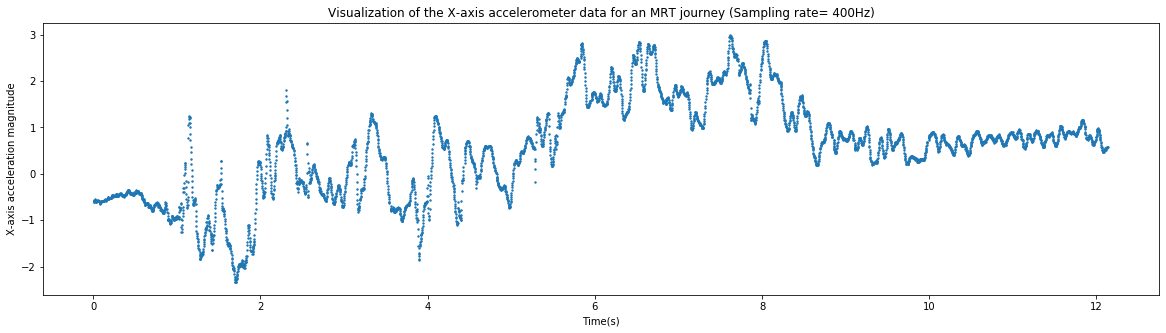

In [5]:
from matplotlib import pyplot as plt
x_data = accm_df.loc[accm_df['JourneyID'] == '36 mrt outram to boon lay standing then sitting', 'time']
x_data = x_data.iloc[0:5000]
y_data = accm_df.loc[accm_df['JourneyID'] == '36 mrt outram to boon lay standing then sitting', 'acc_X']
y_data = y_data.iloc[0:5000]
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.scatter(x_data, y_data, s=2)
ax.set(title='Visualization of the X-axis accelerometer data for an MRT journey (Sampling rate= 400Hz)',
        ylabel='X-axis acceleration magnitude',
        xlabel='Time(s)')

Here, the X-axis of gyrometer data is plotted for one particular MRT journey for 12s.

[Text(0, 0.5, 'X-axis acceleration magnitude'),
 Text(0.5, 0, 'Time(s)'),
 Text(0.5, 1.0, 'Visualization of the X-axis gyrometer data for an MRT journey (Sampling rate= 400Hz)')]

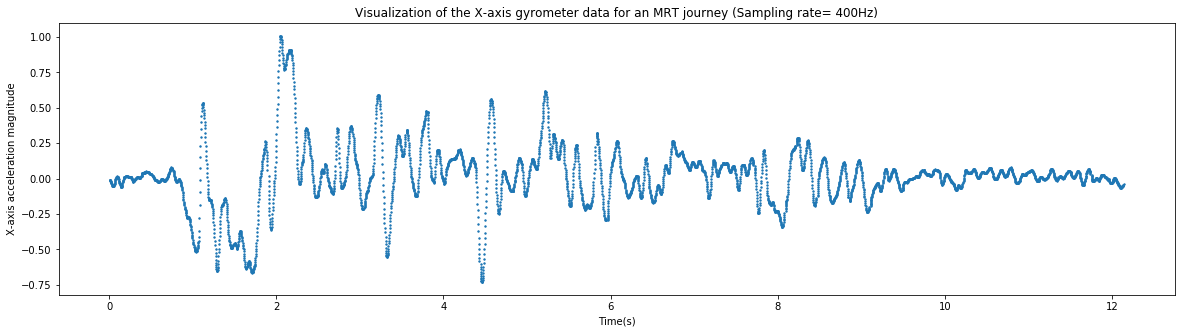

In [6]:
x_data = gyrm_df.loc[gyrm_df['JourneyID'] == '36 mrt outram to boon lay standing then sitting', 'time']
x_data = x_data.iloc[0:5000]
y_data = gyrm_df.loc[gyrm_df['JourneyID'] == '36 mrt outram to boon lay standing then sitting', 'gyr_X']
y_data = y_data.iloc[0:5000]
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.scatter(x_data, y_data, s=2)
ax.set(title='Visualization of the X-axis gyrometer data for an MRT journey (Sampling rate= 400Hz)',
        ylabel='X-axis acceleration magnitude',
        xlabel='Time(s)')

#### 2.3 Visualizing the Effect of Downsampling the Data

Here, we see that as the sampling frequency decreases, the amount of information retained decreases significantly.

In [15]:
acc_data = accm_df.loc[accm_df['JourneyID'] == '36 mrt outram to boon lay standing then sitting']
gyr_data = gyrm_df.loc[accm_df['JourneyID'] == '36 mrt outram to boon lay standing then sitting']

In [16]:
ac_slicers, ac_downsampled, gy_slicers, gy_downsampled = moving_window(acc_data, gyr_data, time_per_journey = 2, overlap = 50, original_sampling_rate = 400, target_sampling_rate=50)

Plotting the downsampled (100 Hz) data (and other sampling rates). These plots can be compared with the original data plotted above.

[Text(0, 0.5, 'X-axis acceleration magnitude'),
 Text(0.5, 0, 'Time(s)'),
 Text(0.5, 1.0, 'Visualization of the X-axis accelerometer data for an MRT journey (Sampling rate = 100Hz)')]

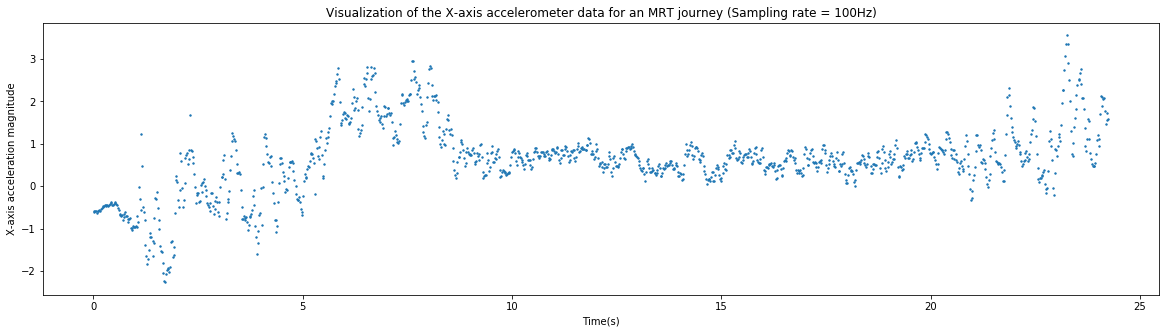

In [17]:
x_data = ac_downsampled.loc[accm_df['JourneyID'] == '36 mrt outram to boon lay standing then sitting', 'time']
x_data = x_data.iloc[0:1250]
y_data = ac_downsampled.loc[accm_df['JourneyID'] == '36 mrt outram to boon lay standing then sitting', 'acc_X']
y_data = y_data.iloc[0:1250]
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.scatter(x_data, y_data, s=2)
ax.set(title='Visualization of the X-axis accelerometer data for an MRT journey (Sampling rate = 100Hz)',
        ylabel='X-axis acceleration magnitude',
        xlabel='Time(s)')

<img src="Images/50Hz.JPG">
<img src="Images/25Hz.JPG">
<img src="Images/10Hz.JPG">

### 3. Normalizing the Data.

3.1) The accelerometer data is summarized using the formula to calculate `a` from `acc_x`, `acc_y`, `acc_z`.
$$a = \sqrt{x^2+y^2+z^2}$$


In [22]:
def magnitude(df_list):
    """
    This step calculates the magnitude of the accelerometer data using the formula 
    a = sqrt(x**2+ y**2+ z**2)
    """
    try:
        for i in range(len(df_list)):
            df_list[i]['Magnitude']= (df_list[i].acc_X**2 + df_list[i].acc_Y**2 + df_list[i].acc_Z**2)**0.5
    except:
        for i in range(len(df_list)):
            df_list[i]['Magnitude']= (df_list[i].gyr_X**2 + df_list[i].gyr_Y**2 + df_list[i].gyr_Z**2)**0.5
        

In [23]:
magnitude(accm_df_list)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
magnitude(gyrm_df_list)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [976]:
magnitude(lacm_df_list)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


3.2) Normalizing `a` to produce `Normalized Signal`

The next step should involve normalizing the data with this formula.

$$ n = x / max|n| $$

In [25]:
def normalize(df_list):
    for i in range(len(df_list)):
        max_value = pd.Series(df_list[i]['Magnitude']).max()
        df_list[i]['Normalized Signal'] = df_list[i]['Magnitude'] / max_value 

In [26]:
normalize(accm_df_list)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [27]:
normalize(gyrm_df_list)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [977]:
normalize(lacm_df_list)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 4. Filtering the data `Normalized Signal` using a Butterworth Low-Pass Filter to produce output `Signal`.

The design of the butterworth low-pass filter is not consistent across papers. In particular, different papers do not agree on the following:
- The order of the filter. 
- The cutoff frequency. 

According to the 'Towards Clustering Accelerometer Data',

    The raw data were then ﬁltered using a second-order forward-backward digital low-pass Butterworth ﬁlter, with a cut-off frequency of 3 Hz (see Figure 2). As demonstrated in previous works, this cut-off frequency is appropriate to ﬁlter the data without losing any information.

In another paper ['Accelerometer and rate gyroscope measurement of kinematics: aninexpensive alternative to optical motion analysis systems'](https://pdf.sciencedirectassets.com.remotexs.ntu.edu.sg/271132/1-s2.0-S0021929000X00875/1-s2.0-S0021929001002317/main.pdf?), a sixth-order  Butterworth  low-pass  filter  with  a  cut-off frequency of 3 Hz was used to remove noise from all the raw data. 

Given that the sampling frequency of our data is 1 sample / 1 second or 1 Hz, the step outlined in the paper cannot be applied, because the nyquist frequency is 0.5 * sampling frequency = 1 Hz, and the filter's cutoff frequency must be between 0 but less than the nyquist frequency. Thus, I referred to another source:

According to [another source](https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones), a cutoff frequency of 0.3 Hz is sufficient. 

    The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used.
    
Thus, the following hyperparameter is used:
- The order of the filter. (Order 3 is used here)
- The cutoff frequency. (0.3 Hz is used here)

For more information on nyquist frequency: 

To decide on the sampling frequency, I referred to this short course on [Sampling, Aliasing & Nyquist Theorem](https://www.youtube.com/watch?v=yWqrx08UeUs). In summary,

    The Nyquist Theorem states that the sampling rate (the nyquist rate) should be at least double the maximum frequency of the signal (the nyquist frequency) to prevent alising. 
    
A few terms:
    
    The nyquist rate is the sampling rate required for a frequency to not be alised.
    The nyquist frequency is the maximum frequency that will not be aliased given a particular sampling rate.

Resources used: [1](https://en.wikipedia.org/wiki/Butterworth_filter) [2](https://ocw.mit.edu/resources/res-6-008-digital-signal-processing-spring-2011/video-lectures/lecture-14-design-of-iir-digital-filters-part-1/) [3](https://ocw.mit.edu/resources/res-6-008-digital-signal-processing-spring-2011/video-lectures/lecture-2-discrete-time-signals-and-systems-part-1/)

    

...........

Before we go on, let's visualize the filter that is being used, and an example of filtered toy data.

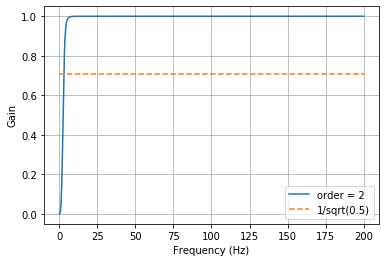

In [28]:
    #visualizing the filter
    from scipy.signal import butter, sosfiltfilt, sosfreqz
    import numpy as np
    from scipy.signal import butter
    #Plotting the filter
    cut = 3
    fs = 400
    nyq = 0.5 * fs
    cutoff = cut / nyq
    order = 2
    sos= butter(N=3, Wn=cutoff, btype='high', analog=False, output='sos')
    w, h = sosfreqz(sos, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %s" %order)
    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='1/sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()


Now, we define the helper function `butter_lowpass_filter` to filter the data and `plot_butterworth_filter` to visualize the pre-and post-filtered data.

In [29]:
#The following is adopted from https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

from scipy.signal import butter, sosfiltfilt, sosfreqz
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

def butter_lowpass_filter(data, cut=3, fs=400, order=2):
    """
    The following function applies the butterworth lowpass filter on the dataframe 'data' 
    of sampling frequency 1Hz. The filter has with a default cutoff frequency of 0.3 and order 3.
    It returns the filtered signal as a Series data.
    """
    nyq = 0.5 * fs
    cutoff = cut / nyq # Normalizing cutoff frequency in terms of nyquist frequency
    #For digital filters, Wn are in the same units as fs and are normalized from 0 to 1, where 1 is the Nyquist frequency.
    sos= butter(N=order, Wn=cutoff, btype='high', analog=False, output='sos')
    y = sosfiltfilt(sos, data, padtype='even')
    return y

def plot_butterworth_filter(index):
    """ 
    The following function plots the pre-filtered and post-filtered accelerometer data. The filter used 
    is a butterworth lowpass filter with a cutoff frequency of 0.3Hz and order 3.
    """
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 400
    cut = 3.0
#    data = list_of_overlapped_journeys[index]['a']   
    data = accm_df_list[index]['Normalized Signal']
    travel_mode = str(accm_df_list[index].iloc[0,1])
    # Filter a noisy signal.
    T = len(data)
    nsamples = T * fs
    t = np.linspace(0, 2, len(accm_df_list[index]), endpoint=True)
    y = butter_lowpass_filter(data)
    
    #Plotting noisy and filtered data together
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    ax[0].plot(t, data, label='Noisy signal', dashes = [2,2])
    #ax[0].plot(t, y, label='Filtered signal') #(%g Hz)' % f0)
    ax[0].set_xlabel('time (seconds)')
    ax[0].grid(True)
    ax[0].autoscale(enable=True, axis='both', tight=True)
    ax[0].legend(loc='upper left')
    ax[0].set_title('Journey'+str(index)+travel_mode)

    #plotting only filtered data
    ax[1].plot(t, y, label='Filtered signal') #(%g Hz)' % f0)
    ax[1].set_xlabel('time (seconds)')
    ax[1].grid(True)
    ax[1].legend(loc='upper left')
    ax[1].set_title('Journey'+str(index)+travel_mode)
    
    plt.show()

In [30]:
#Applying the filter on the normalized signal.
def filter(df_list):
    FilteredSignal = []
    for i in range(len(df_list)):
            FilteredSignal.append(butter_lowpass_filter(df_list[i]['Normalized Signal'])) #change ['a'] to NormalizedSignal if want to use normalized signal
            df_list[i]['Filtered Signal'] = FilteredSignal[i]

In [31]:
filter(accm_df_list)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
filter(gyrm_df_list)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [979]:
filter(lacm_df_list)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's visualize the unfiltered and filtered signal, with one journey from each travel mode.

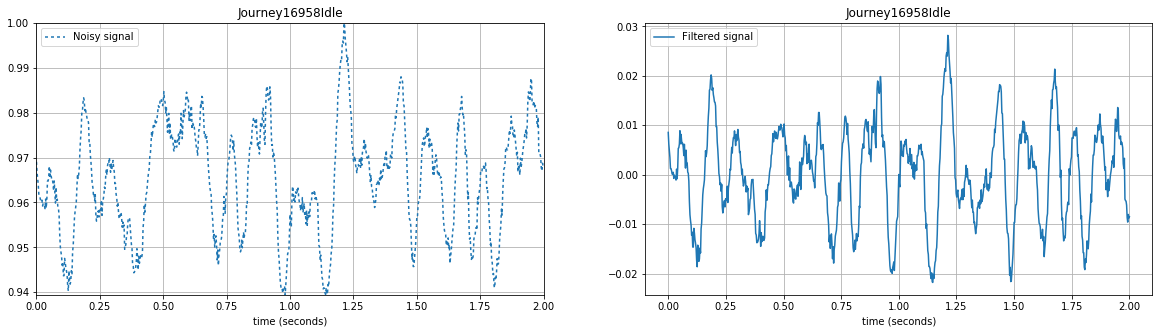

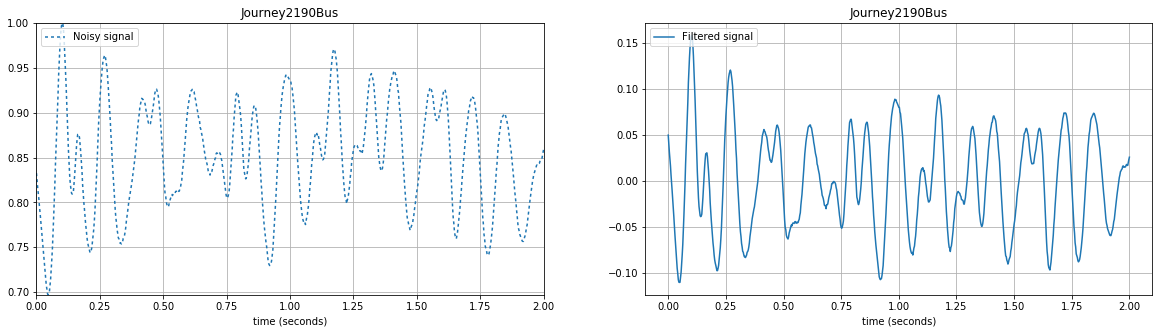

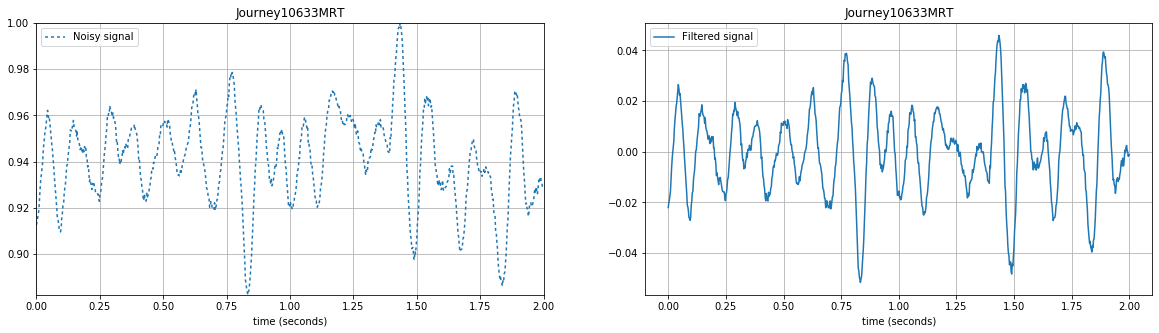

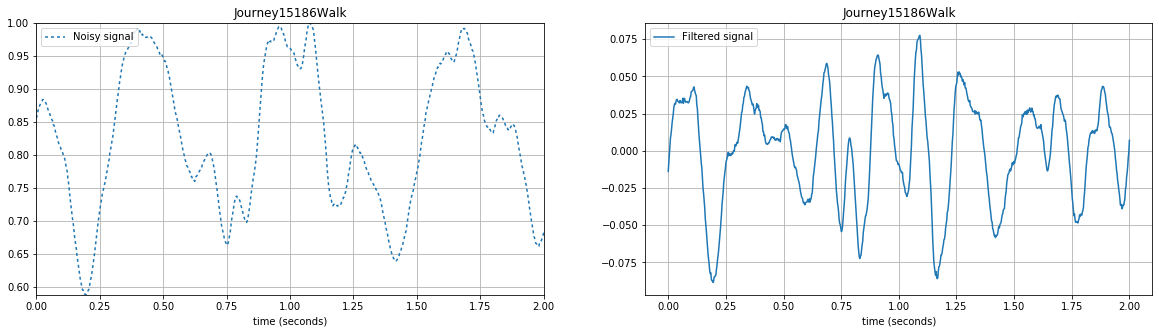

In [33]:
import random
random.seed(0)
list_of_list=[idle_overlapped_journeys, #car_overlapped_journeys,
                     bus_overlapped_journeys,mrt_overlapped_journeys, walk_overlapped_journeys]
for journey_list in list_of_list:
    randomnum = random.choice(journey_list)
    plot_butterworth_filter(randomnum)

Yes! We successfully filtered the noisy data. 

### 5. Extract time-domain summary about the normalized and `Filtered Signal`.
Next, we can summarize the normalized signal using mean, median, standard deviation (STD), root mean square (RMS), and variance. The rest of the features are justified in the paper Human Activity Recognition Using 
Accelerometer and Gyroscope Sensors.?

In [34]:
def ent(data):
    p_data= data/len(data) # calculates the probabilities
    entropy=scipy.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy

In [35]:
import numpy as np
from scipy.stats import iqr, skew, kurtosis
def summarize(df_list):
    t_f_summary = pd.DataFrame()
    t_f_summary.reset_index()

    JourneyID, Mode, tMean, tMedian, tRMS, tVariance, tMin, tMax, tRange, tIQR, tSkew, tKurtosis, t10percent, t25percent, t50percent, t75percent, t90percent, tEntropy = [[] for i in range(18)]
    JourneyID = np.arange(0,len(df_list))
    for i in range(len(df_list)):
        journey_df = df_list[i]
        Mode.append(df_list[0].loc[0,'Mode'])
        #obtain signal
        signal = journey_df['Filtered Signal'].to_numpy()
        tMean.append(np.mean(signal)) 
        tMedian.append(np.median(signal))
        tRMS.append(np.sqrt(np.mean(np.square((signal)))))
        tVariance.append(np.var(signal))
        min = signal.min()
        max = signal.max()
        tMin.append(min)
        tMax.append(max)
        tRange.append(max-min)
        tIQR.append(iqr(signal))
        tSkew.append(skew(signal))
        tKurtosis.append(kurtosis(signal))  
        t10percent.append(np.percentile(signal,10))
        t25percent.append(np.percentile(signal,25))                
        t50percent.append(np.percentile(signal,50))                
        t75percent.append(np.percentile(signal,75))                      
        t90percent.append(np.percentile(signal,90))

    feature_list = [JourneyID, Mode, tMean, tMedian, tRMS, tVariance, tMin, tMax, tRange, tIQR, tSkew, tKurtosis, 
    t10percent, t25percent, t50percent, t75percent, t90percent]

    for i in feature_list:
        t_f_summary = pd.concat([t_f_summary, pd.Series(i)], axis = 1)
    t_f_summary.columns = ['JourneyID', 'Mode', 'tMean', 'tMedian', 
                    'tRMS', 'tVariance', 'tMin', 'tMax', 
                    'tRange', 'tIQR', 'tSkew', 'tKurtosis', 
                    't10percent', 't25percent', 't50percent', 't75percent', 't90percent']
    return t_f_summary

In [36]:
accm_t_f_summary = summarize(accm_df_list)

In [37]:
gyrm_t_f_summary = summarize(gyrm_df_list)

In [980]:
lacm_t_f_summary = summarize(lacm_df_list)

In [38]:
gyrm_t_f_summary

,JourneyID,Mode,tMean,tMedian,tRMS,tVariance,tMin,tMax,tRange,tIQR,tSkew,tKurtosis,t10percent,t25percent,t50percent,t75percent,t90percent
0,0,Bus,-0.000190,0.003698,0.099725,0.009945,-0.355458,0.398560,0.754018,0.105684,0.358311,1.994222,-0.114939,-0.059082,0.003698,0.046603,0.103398
1,1,Bus,-0.000373,0.001217,0.049734,0.002473,-0.124081,0.200065,0.324146,0.043780,0.233596,1.866909,-0.064855,-0.021815,0.001217,0.021964,0.058552
2,2,Bus,-0.000576,0.001437,0.056045,0.003141,-0.237579,0.161208,0.398787,0.044724,-0.801644,2.566698,-0.067598,-0.019911,0.001437,0.024813,0.063465
3,3,Bus,0.000864,0.001941,0.051680,0.002670,-0.237009,0.158288,0.395297,0.054676,-0.886726,3.498043,-0.048144,-0.022839,0.001941,0.031837,0.058482
4,4,Bus,0.000153,-0.012913,0.100110,0.010022,-0.264987,0.422036,0.687023,0.118334,0.904186,2.311587,-0.111108,-0.062901,-0.012913,0.055433,0.114847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17545,17545,Bus,-0.000519,0.000019,0.099167,0.009834,-0.395489,0.269906,0.665395,0.093002,-0.412554,1.986364,-0.106304,-0.046540,0.000019,0.046462,0.124586
17546,17546,Bus,-0.000857,-0.007547,0.116295,0.013524,-0.364093,0.402507,0.766600,0.115108,0.579630,1.558824,-0.131438,-0.064750,-0.007547,0.050358,0.137043
17547,17547,Bus,0.000247,-0.005576,0.101836,0.010371,-0.311576,0.402463,0.714038,0.090930,0.846704,2.779929,-0.107445,-0.048491,-0.005576,0.042438,0.103542
17548,17548,Bus,0.000101,-0.001657,0.122121,0.014914,-0.397308,0.386012,0.783320,0.150010,0.180126,0.215328,-0.161701,-0.075440,-0.001657,0.074571,0.158956


This is a working dataframe with the t summary! Next, let's move on to the frequency domain.

## Frequency-domain

### F1) Remove mean acceleration from `Filtered Signal`.



In [39]:
for i in range(len(accm_df_list)):
    accm_df_list[i]['Signal_with_mean_removed'] = accm_df_list[i]['Filtered Signal'] - np.mean(accm_df_list[i]['Filtered Signal'])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
for i in range(len(gyrm_df_list)):
    gyrm_df_list[i]['Signal_with_mean_removed'] = gyrm_df_list[i]['Filtered Signal'] - np.mean(gyrm_df_list[i]['Filtered Signal'])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [982]:
for i in range(len(lacm_df_list)):
    lacm_df_list[i]['Signal_with_mean_removed'] = lacm_df_list[i]['Filtered Signal'] - np.mean(lacm_df_list[i]['Filtered Signal'])

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
gyrm_df_list[0]

,JourneyID,Mode,gyr_X,gyr_Y,gyr_Z,time,Magnitude,Normalized Signal,Filtered Signal,Signal_with_mean_removed
0,1 bus - bottom holding on hand,Bus,-0.19305,0.02512,-0.06044,0.0040,0.203844,0.118940,-0.049098,-0.048908
1,1 bus - bottom holding on hand,Bus,-0.17472,-0.02742,-0.05556,0.0041,0.185380,0.108167,-0.061047,-0.060857
2,1 bus - bottom holding on hand,Bus,-0.15151,-0.07262,-0.05311,0.0068,0.176209,0.102816,-0.067648,-0.067458
3,1 bus - bottom holding on hand,Bus,-0.13074,-0.11538,-0.05067,0.0068,0.181585,0.105952,-0.065834,-0.065644
4,1 bus - bottom holding on hand,Bus,-0.10631,-0.15203,-0.04700,0.0113,0.191374,0.111664,-0.061519,-0.061329
...,...,...,...,...,...,...,...,...,...,...
819,1 bus - bottom holding on hand,Bus,-0.02689,-0.00054,0.02752,1.9867,0.038480,0.022453,-0.006717,-0.006527
820,1 bus - bottom holding on hand,Bus,-0.03178,0.00801,0.02630,1.9904,0.042022,0.024519,-0.004323,-0.004133
821,1 bus - bottom holding on hand,Bus,-0.03667,0.01168,0.02630,1.9904,0.046613,0.027198,-0.001333,-0.001143
822,1 bus - bottom holding on hand,Bus,-0.04033,0.01412,0.02386,1.9962,0.048941,0.028556,0.000319,0.000510


### F2) Apply fourier transform and Power Spectrum Density (PSD) to ``a``

Note: To understand signal processing, I took the following [IBM Signal Processing Course](https://www.coursera.org/learn/advanced-machine-learning-signal-processing/exam/abXRb/wavelet-transform) and used information from [a crash course](https://steemit.com/stemng/@henrychidiebere/digital-signal-processing-a-crash-course-on-signals-and-systems). [This video](https://www.youtube.com/watch?v=spUNpyF58BY) is great for understanding Fourier Transform.

In [80]:
#http://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/
from scipy.signal import welch
from scipy.fftpack import fft
def get_psd_values(df):
    N = len(df)
    t_n = 2 #number of seconds considered
    T = t_n / N
    f_s = 1 / T
    f_values, psd_values = welch(df, fs=f_s)
    return f_values, psd_values

def get_fft_values(df):
    N = len(df)
    t_n = 2 #number of seconds considered
    T = t_n / N
    f_s = 1 / T
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(df)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values #returns magnitude of each frequency bin

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(df):
    t_n = len(df)
    N = len(df)
    T = 1
    f_s = 1/T
    autocorr_values = autocorr(df)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values
 

In [527]:
def FourierPSD(df_list):

    journey_PSD = []
    journey_Fourier=[]

    for i in range(len(df_list)): 

        
        freq, PSD = get_psd_values(df_list[i]['Signal_with_mean_removed'])
        
        journey_PSD.append(pd.DataFrame(
             list(zip(freq, PSD)),
             columns = ['Frequency','Amplitude']))    
        
        freq, Amplitude = get_fft_values(accm_df_list[i]['Signal_with_mean_removed'])

        
        journey_Fourier.append(pd.DataFrame(
             list(zip(freq, Amplitude)),
             columns = ['Frequency','Amplitude'])  )    


    return journey_Fourier, journey_PSD#, journey_Autocorrelation

In [528]:
#check efficiency of algorithm
import time
start_time = time.time()

accm_journey_Fourier, accm_journey_PSD = FourierPSD(accm_df_list)      

print("--- %s seconds ---" % (time.time() - start_time))
                                      
#journey_Fourier = pd.concat(journey_Fourier,journey_Fourier_freq)

--- 48.624629735946655 seconds ---


In [529]:
start_time = time.time()
#https://stackoverflow.com/questions/44268488/scipy-signal-spectrogram-nfft-parameter#44271701 FFT paramters
gyrm_journey_Fourier, gyrm_journey_PSD = FourierPSD(gyrm_df_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 47.95845150947571 seconds ---


In [983]:
start_time = time.time()
#https://stackoverflow.com/questions/44268488/scipy-signal-spectrogram-nfft-parameter#44271701 FFT paramters
lacm_journey_Fourier, lacm_journey_PSD = FourierPSD(lacm_df_list)
print("--- %s seconds ---" % (time.time() - start_time))

--- 96.01987600326538 seconds ---


Now that we have extracted the Fourier Transform, the coefficients of the Fourier transform is useful to tell us the magnitude of the signal at each frequency. This might be the key to differentiate between MRT or bus journeys. [This video on Discrete Fourier Transform](https://www.youtube.com/watch?v=mkGsMWi_j4Q) explains the math behind it.

In [511]:
def get_amplitude(journey_Fourier):
    
    Fourier_Amplitude_list = []
   
    for i in range(len(journey_Fourier)):
        Fourier_Amplitude = journey_Fourier[i]
        Fourier_Amplitude.reset_index(inplace=True, drop=True)
        Fourier_Amplitude_list.append(Fourier_Amplitude['Amplitude'])

    Fourier_Amplitude_df = pd.DataFrame(Fourier_Amplitude_list)
    #Fourier_Amplitude_df.loc[:,'JourneyID'] = [i for i in range(len(accom_journey_Fourier_sample))]
    return Fourier_Amplitude_df

In [512]:
start_time = time.time()
accm_Fourier_Amplitude_df = get_amplitude(accm_journey_Fourier)
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.191231727600098 seconds ---


In [513]:
start_time = time.time()
gyrm_Fourier_Amplitude_df = get_amplitude(gyrm_journey_Fourier)
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.373689651489258 seconds ---


In [984]:
start_time = time.time()
lacm_Fourier_Amplitude_df = get_amplitude(lacm_journey_Fourier)
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.9914255142211914 seconds ---


In [514]:
accm_Fourier_Amplitude_df = accm_Fourier_Amplitude_df.dropna(axis=1, how='any')

In [515]:
gyrm_Fourier_Amplitude_df = gyrm_Fourier_Amplitude_df.dropna(axis=1, how='any')

In [985]:
lacm_Fourier_Amplitude_df = lacm_Fourier_Amplitude_df.dropna(axis=1, how='any')

### F3. Extract summary statistics in the frequency-domain

In [355]:
#https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python#39210767
#principles:https://stackoverflow.com/questions/30418391/what-is-frequency-domain-entropy-in-fft-result-and-how-to-calculate-it
import scipy
def ent(data):
    p_data= data/len(data) # calculates the probabilities
    entropy=scipy.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy

Energy calculation from [here](https://en.wikibooks.org/wiki/Signals_and_Systems/Fourier_Series_Analysis):


    With Parseval's theorem, we can calculate the amount of energy being used by a signal in different parts of the spectrum. This is useful in many applications, such as filtering, that we will discuss later.

    We know from Parseval's theorem that to obtain the energy of the harmonics of the signal that we need to square the frequency representation in order to view the energy. We can define the energy spectral density of the signal as the square of the Fourier transform of the signal:

$${\displaystyle {\mathcal {E}}_{F}(\theta )={\mathcal {F}}^{2}(\theta )}$$

    The magnitude of the graph at different frequencies represents the amount energy located within those frequency components. 
    
More reference: [Energy Calculation Reference 1](https://dsp.stackexchange.com/questions/20246/energy-calculation-in-frequency-domain#20250), [2](https://aaronscher.com/Course_materials/Communication_Systems/documents/Energy_signals_matlab_tutorial.pdf)

In [530]:
#Number of frequency bins: https://dsp.stackexchange.com/questions/40766/calculating-values-of-frequency-bins-in-python#40769
start_time = time.time()

accm_fEnergy  = []
accm_fEntropy = []
accm_JourneyID = []
for i in range(len(accm_df_list)):
        #accm_journey_Fourier[i].reset_index(drop=True)
        accm_JourneyID.append(accm_df_list[i].iloc[0,1])
        accm_fEnergy.append(np.sum(accm_journey_Fourier[i]['Amplitude']**2/len(accm_journey_Fourier[i]['Amplitude'])))
        accm_fEntropy.append(ent(accm_journey_PSD[i]['Amplitude']))
        
        accm_t_f_summary.loc[i,'JourneyID'] = accm_JourneyID[i]
        accm_t_f_summary.loc[i,'fEntropy'] = accm_fEntropy[i]
        accm_t_f_summary.loc[i,'fEnergy'] = accm_fEnergy[i]
        
        #accm_journey_Fourier[i] = accm_journey_Fourier[i]
        #pd.concat([accm_t_f_summary,accm_journey_Fourier], axis=1)
       # t_f_summary.loc[i,'fMean'] = ent(unique_journey[i]['Fourier Transform']) 

print("--- %s seconds ---" % (time.time() - start_time))

--- 75.21057271957397 seconds ---


In [535]:
accm_Fourier_Amplitude_df.reset_index(inplace=True, drop=True)

In [541]:
accm_t_f_summary_copy = accm_t_f_summary
accm_t_f_summary = pd.concat([accm_t_f_summary,accm_Fourier_Amplitude_df], axis = 1)

In [543]:
accm_t_f_summary.drop(columns=['Mode'], inplace=True)

In [545]:
gyrm_fEnergy  = []
gyrm_fEntropy = []
gyrm_JourneyID = []
for i in range(len(gyrm_df_list)):
        gyrm_journey_Fourier[i].reset_index()
        gyrm_JourneyID.append(gyrm_df_list[i].iloc[0,1])
        gyrm_fEnergy.append(np.sum(gyrm_journey_Fourier[i]['Amplitude']**2/len(gyrm_journey_Fourier[i]['Amplitude'])))
        gyrm_fEntropy.append(ent(gyrm_journey_PSD[i]['Amplitude']))
        
        gyrm_t_f_summary.loc[i,'JourneyID'] = gyrm_JourneyID[i]
        gyrm_t_f_summary.loc[i,'fEntropy'] = gyrm_fEntropy[i]
        gyrm_t_f_summary.loc[i,'fEnergy'] = gyrm_fEnergy[i]
       # t_f_summary.loc[i,'fMean'] = ent(unique_journey[i]['Fourier Transform']) 
#write a more efficient code

In [546]:
gyrm_t_f_summary

,JourneyID,Mode,tMean,tMedian,tRMS,tVariance,tMin,tMax,tRange,tIQR,tSkew,tKurtosis,t10percent,t25percent,t50percent,t75percent,t90percent,fEntropy,fEnergy
0,Bus,Bus,-0.000190,0.003698,0.099725,0.009945,-0.355458,0.398560,0.754018,0.105684,0.358311,1.994222,-0.114939,-0.059082,0.003698,0.046603,0.103398,2.108006,0.000006
1,Bus,Bus,-0.000373,0.001217,0.049734,0.002473,-0.124081,0.200065,0.324146,0.043780,0.233596,1.866909,-0.064855,-0.021815,0.001217,0.021964,0.058552,1.745849,0.000003
2,Bus,Bus,-0.000576,0.001437,0.056045,0.003141,-0.237579,0.161208,0.398787,0.044724,-0.801644,2.566698,-0.067598,-0.019911,0.001437,0.024813,0.063465,2.199052,0.000003
3,Bus,Bus,0.000864,0.001941,0.051680,0.002670,-0.237009,0.158288,0.395297,0.054676,-0.886726,3.498043,-0.048144,-0.022839,0.001941,0.031837,0.058482,2.422772,0.000003
4,Bus,Bus,0.000153,-0.012913,0.100110,0.010022,-0.264987,0.422036,0.687023,0.118334,0.904186,2.311587,-0.111108,-0.062901,-0.012913,0.055433,0.114847,2.479216,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17545,Bus,Bus,-0.000519,0.000019,0.099167,0.009834,-0.395489,0.269906,0.665395,0.093002,-0.412554,1.986364,-0.106304,-0.046540,0.000019,0.046462,0.124586,2.310427,0.000008
17546,Bus,Bus,-0.000857,-0.007547,0.116295,0.013524,-0.364093,0.402507,0.766600,0.115108,0.579630,1.558824,-0.131438,-0.064750,-0.007547,0.050358,0.137043,2.392930,0.000007
17547,Bus,Bus,0.000247,-0.005576,0.101836,0.010371,-0.311576,0.402463,0.714038,0.090930,0.846704,2.779929,-0.107445,-0.048491,-0.005576,0.042438,0.103542,2.620838,0.000005
17548,Bus,Bus,0.000101,-0.001657,0.122121,0.014914,-0.397308,0.386012,0.783320,0.150010,0.180126,0.215328,-0.161701,-0.075440,-0.001657,0.074571,0.158956,2.632390,0.000002


In [547]:
gyrm_Fourier_Amplitude_df.reset_index(inplace=True, drop=True)

In [548]:
gyrm_t_f_summary_copy = gyrm_t_f_summary
gyrm_t_f_summary = pd.concat([gyrm_t_f_summary,gyrm_Fourier_Amplitude_df], axis = 1)

In [550]:
gyrm_t_f_summary.drop(columns=['Mode'], inplace=True)

In [552]:
gyrm_t_f_summary

,JourneyID,tMean,tMedian,tRMS,tVariance,tMin,tMax,tRange,tIQR,tSkew,...,340,341,342,343,344,345,346,347,348,349
0,Bus,-0.000190,0.003698,0.099725,0.009945,-0.355458,0.398560,0.754018,0.105684,0.358311,...,0.000216,0.000205,0.000204,0.000321,0.000168,0.000114,0.000162,0.000221,0.000039,0.000160
1,Bus,-0.000373,0.001217,0.049734,0.002473,-0.124081,0.200065,0.324146,0.043780,0.233596,...,0.000150,0.000109,0.000032,0.000174,0.000123,0.000098,0.000074,0.000110,0.000091,0.000110
2,Bus,-0.000576,0.001437,0.056045,0.003141,-0.237579,0.161208,0.398787,0.044724,-0.801644,...,0.000066,0.000085,0.000098,0.000056,0.000102,0.000034,0.000109,0.000070,0.000057,0.000049
3,Bus,0.000864,0.001941,0.051680,0.002670,-0.237009,0.158288,0.395297,0.054676,-0.886726,...,0.000140,0.000139,0.000131,0.000062,0.000047,0.000075,0.000043,0.000068,0.000121,0.000115
4,Bus,0.000153,-0.012913,0.100110,0.010022,-0.264987,0.422036,0.687023,0.118334,0.904186,...,0.000092,0.000135,0.000071,0.000032,0.000171,0.000053,0.000103,0.000051,0.000136,0.000103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17545,Bus,-0.000519,0.000019,0.099167,0.009834,-0.395489,0.269906,0.665395,0.093002,-0.412554,...,0.000072,0.000076,0.000039,0.000111,0.000054,0.000059,0.000047,0.000046,0.000056,0.000013
17546,Bus,-0.000857,-0.007547,0.116295,0.013524,-0.364093,0.402507,0.766600,0.115108,0.579630,...,0.000096,0.000100,0.000076,0.000063,0.000085,0.000052,0.000070,0.000064,0.000066,0.000022
17547,Bus,0.000247,-0.005576,0.101836,0.010371,-0.311576,0.402463,0.714038,0.090930,0.846704,...,0.000058,0.000048,0.000076,0.000104,0.000072,0.000048,0.000075,0.000110,0.000019,0.000065
17548,Bus,0.000101,-0.001657,0.122121,0.014914,-0.397308,0.386012,0.783320,0.150010,0.180126,...,0.000078,0.000091,0.000039,0.000017,0.000046,0.000143,0.000166,0.000131,0.000061,0.000039


In [986]:
lacm_fEnergy  = []
lacm_fEntropy = []
lacm_JourneyID = []
for i in range(len(lacm_df_list)):
        lacm_journey_Fourier[i].reset_index()
        lacm_JourneyID.append(lacm_df_list[i].iloc[0,1])
        lacm_fEnergy.append(np.sum(lacm_journey_Fourier[i]['Amplitude']**2/len(lacm_journey_Fourier[i]['Amplitude'])))
        lacm_fEntropy.append(ent(lacm_journey_PSD[i]['Amplitude']))
        
        lacm_t_f_summary.loc[i,'JourneyID'] = lacm_JourneyID[i]
        lacm_t_f_summary.loc[i,'fEntropy'] = lacm_fEntropy[i]
        lacm_t_f_summary.loc[i,'fEnergy'] = lacm_fEnergy[i]
       # t_f_summary.loc[i,'fMean'] = ent(unique_journey[i]['Fourier Transform']) 
#write a more efficient code

In [998]:
lacm_Fourier_Amplitude_df.reset_index(inplace=True, drop=True)
lacm_t_f_summary_copy = lacm_t_f_summary
lacm_t_f_summary = pd.concat([lacm_t_f_summary,lacm_Fourier_Amplitude_df], axis = 1)

In [553]:
#Dropping invalid values.
gyrm_t_f_summary.dropna(inplace=True)
accm_t_f_summary.dropna(inplace=True)

In [1001]:
lacm_t_f_summary.dropna(inplace=True)

In [1002]:
lacm_t_f_summary

,JourneyID,tMean,tMedian,tRMS,tVariance,tMin,tMax,tRange,tIQR,tSkew,...,340,341,342,343,344,345,346,347,348,349
0,Bus,-0.000190,0.003698,0.099725,0.009945,-0.355458,0.398560,0.754018,0.105684,0.358311,...,0.000216,0.000205,0.000204,0.000321,0.000168,0.000114,0.000162,0.000221,0.000039,0.000160
1,Bus,-0.000373,0.001217,0.049734,0.002473,-0.124081,0.200065,0.324146,0.043780,0.233596,...,0.000150,0.000109,0.000032,0.000174,0.000123,0.000098,0.000074,0.000110,0.000091,0.000110
2,Bus,-0.000576,0.001437,0.056045,0.003141,-0.237579,0.161208,0.398787,0.044724,-0.801644,...,0.000066,0.000085,0.000098,0.000056,0.000102,0.000034,0.000109,0.000070,0.000057,0.000049
3,Bus,0.000864,0.001941,0.051680,0.002670,-0.237009,0.158288,0.395297,0.054676,-0.886726,...,0.000140,0.000139,0.000131,0.000062,0.000047,0.000075,0.000043,0.000068,0.000121,0.000115
4,Bus,0.000153,-0.012913,0.100110,0.010022,-0.264987,0.422036,0.687023,0.118334,0.904186,...,0.000092,0.000135,0.000071,0.000032,0.000171,0.000053,0.000103,0.000051,0.000136,0.000103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17545,Bus,-0.000519,0.000019,0.099167,0.009834,-0.395489,0.269906,0.665395,0.093002,-0.412554,...,0.000072,0.000076,0.000039,0.000111,0.000054,0.000059,0.000047,0.000046,0.000056,0.000013
17546,Bus,-0.000857,-0.007547,0.116295,0.013524,-0.364093,0.402507,0.766600,0.115108,0.579630,...,0.000096,0.000100,0.000076,0.000063,0.000085,0.000052,0.000070,0.000064,0.000066,0.000022
17547,Bus,0.000247,-0.005576,0.101836,0.010371,-0.311576,0.402463,0.714038,0.090930,0.846704,...,0.000058,0.000048,0.000076,0.000104,0.000072,0.000048,0.000075,0.000110,0.000019,0.000065
17548,Bus,0.000101,-0.001657,0.122121,0.014914,-0.397308,0.386012,0.783320,0.150010,0.180126,...,0.000078,0.000091,0.000039,0.000017,0.000046,0.000143,0.000166,0.000131,0.000061,0.000039


In [1003]:
t_f_summary = pd.concat([gyrm_t_f_summary,accm_t_f_summary.iloc[:,1:], lacm_t_f_summary.iloc[:,1:]], axis=1)


In [1004]:
t_f_summary

,JourneyID,tMean,tMedian,tRMS,tVariance,tMin,tMax,tRange,tIQR,tSkew,...,340,341,342,343,344,345,346,347,348,349
0,Bus,-0.000190,0.003698,0.099725,0.009945,-0.355458,0.398560,0.754018,0.105684,0.358311,...,0.000216,0.000205,0.000204,0.000321,0.000168,0.000114,0.000162,0.000221,0.000039,0.000160
1,Bus,-0.000373,0.001217,0.049734,0.002473,-0.124081,0.200065,0.324146,0.043780,0.233596,...,0.000150,0.000109,0.000032,0.000174,0.000123,0.000098,0.000074,0.000110,0.000091,0.000110
2,Bus,-0.000576,0.001437,0.056045,0.003141,-0.237579,0.161208,0.398787,0.044724,-0.801644,...,0.000066,0.000085,0.000098,0.000056,0.000102,0.000034,0.000109,0.000070,0.000057,0.000049
3,Bus,0.000864,0.001941,0.051680,0.002670,-0.237009,0.158288,0.395297,0.054676,-0.886726,...,0.000140,0.000139,0.000131,0.000062,0.000047,0.000075,0.000043,0.000068,0.000121,0.000115
4,Bus,0.000153,-0.012913,0.100110,0.010022,-0.264987,0.422036,0.687023,0.118334,0.904186,...,0.000092,0.000135,0.000071,0.000032,0.000171,0.000053,0.000103,0.000051,0.000136,0.000103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17545,Bus,-0.000519,0.000019,0.099167,0.009834,-0.395489,0.269906,0.665395,0.093002,-0.412554,...,0.000072,0.000076,0.000039,0.000111,0.000054,0.000059,0.000047,0.000046,0.000056,0.000013
17546,Bus,-0.000857,-0.007547,0.116295,0.013524,-0.364093,0.402507,0.766600,0.115108,0.579630,...,0.000096,0.000100,0.000076,0.000063,0.000085,0.000052,0.000070,0.000064,0.000066,0.000022
17547,Bus,0.000247,-0.005576,0.101836,0.010371,-0.311576,0.402463,0.714038,0.090930,0.846704,...,0.000058,0.000048,0.000076,0.000104,0.000072,0.000048,0.000075,0.000110,0.000019,0.000065
17548,Bus,0.000101,-0.001657,0.122121,0.014914,-0.397308,0.386012,0.783320,0.150010,0.180126,...,0.000078,0.000091,0.000039,0.000017,0.000046,0.000143,0.000166,0.000131,0.000061,0.000039


Now we have a working data set!

From here, we obtain a dataset that is very similar to that provided by [this Kaggle competition/notebook](https://www.kaggle.com/morrisb/what-does-your-smartphone-know-about-you). The dataset consists of a summary of the phone sensor data in f-domain / t-domain. This notebook provides excellent analysis of the dataset provided by the competition, and is able to achieve 95.57% accuracy using a LGBM classifer without tuning.


# Feature Selection

After we're done with preprocessing the data, there are two ways we can go about conducting feature selection. Firstly, we can use PCA and select the number of features using a scree plot.. Secondly,  we can use to correlation matrix to select the number of features

In [1092]:
#Separating dataframe into feature (X) and output (y)
from sklearn import preprocessing
X = t_f_summary.iloc[:,1:]
#X= preprocessing.scale(X)
X = X.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x))) #normalize the data in the summary dataframe.
y = t_f_summary.iloc[:,0]

In [1075]:
X

,tMean,tMedian,tRMS,tVariance,tMin,tMax,tRange,tIQR,tSkew,tKurtosis,...,tIQR,tSkew,tKurtosis,t10percent,t25percent,t50percent,t75percent,t90percent,fEntropy,fEnergy
0,-0.021581,0.073607,-0.051457,-0.068905,-0.052823,0.058480,0.075015,-0.083924,0.008332,0.003138,...,-0.083924,0.008332,0.003138,0.059442,0.050803,0.073607,-0.104570,-0.111848,-0.050487,-0.000292
1,-0.041981,0.045727,-0.334699,-0.271294,0.316356,-0.183185,-0.322411,-0.292290,-0.000847,0.002485,...,-0.292290,-0.000847,0.002485,0.251075,0.287518,0.045727,-0.256701,-0.277705,-0.149997,-0.020909
2,-0.064650,0.048201,-0.298944,-0.253218,0.135262,-0.230493,-0.253404,-0.289111,-0.077035,0.006075,...,-0.289111,-0.077035,0.006075,0.240581,0.299611,0.048201,-0.239113,-0.259536,-0.025471,-0.029858
3,0.096163,0.053867,-0.323676,-0.265966,0.136171,-0.234047,-0.256630,-0.255615,-0.083297,0.010853,...,-0.255615,-0.083297,0.010853,0.315015,0.281016,0.053867,-0.195743,-0.277963,0.036001,-0.029410
4,0.016736,-0.113060,-0.049276,-0.066821,0.091530,0.087062,0.013077,-0.041347,0.048505,0.004766,...,-0.041347,0.048505,0.004766,0.074099,0.026543,-0.113060,-0.050046,-0.069505,0.051510,-0.027605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17545,-0.058240,0.032264,-0.054618,-0.071917,-0.116696,-0.098154,-0.006919,-0.126612,-0.048400,0.003098,...,-0.126612,-0.048400,0.003098,0.092482,0.130467,0.032264,-0.105439,-0.033489,0.005132,0.027906
17546,-0.096021,-0.052752,0.042426,0.028034,-0.066601,0.063285,0.086648,-0.052205,0.024620,0.000905,...,-0.052205,0.024620,0.000905,-0.003689,0.014797,-0.052752,-0.081383,0.012583,0.027801,0.016782
17547,0.027197,-0.030613,-0.039496,-0.057379,0.017194,0.063231,0.038053,-0.133586,0.044275,0.007169,...,-0.133586,0.044275,0.007169,0.088115,0.118071,-0.030613,-0.130283,-0.111316,0.090423,-0.009898
17548,0.010950,0.013427,0.075436,0.065679,-0.119599,0.043203,0.102106,0.065273,-0.004782,-0.005987,...,0.065273,-0.004782,-0.005987,-0.119484,-0.053104,0.013427,0.068119,0.093624,0.093597,-0.038776


# Visualization with PCA

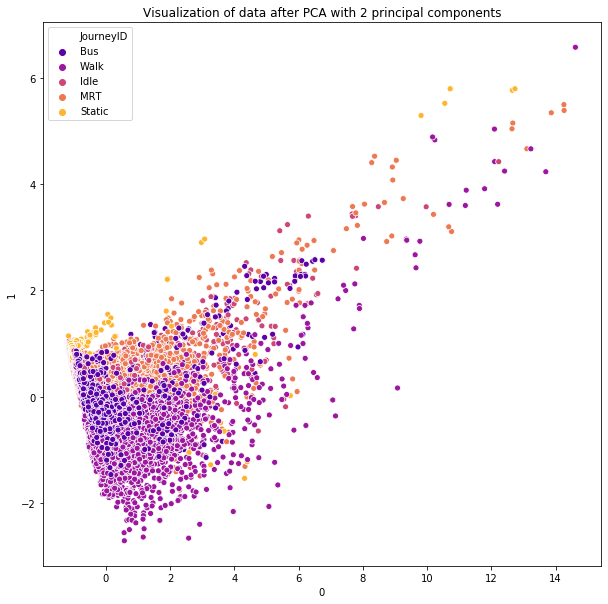

In [1093]:
import seaborn as sns
pca = PCA(n_components = 2, random_state = 0)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X))
y_pca=y.reset_index(drop=True)

plt.figure(figsize=(10,10))
plt.title('Visualization of data after PCA with 2 principal components')
plt.ylabel('Principal component 2')
plt.xlabel('Principal component 1')
sns.scatterplot(X_pca[0], X_pca[1], hue = y_pca, palette='plasma')
plt.show()

### Feature Selection: PCA and Scree Plot

First, we select the number of features to be selected. To do so, we would like to use PCA to explain 95% variance in the dataset.

In [1140]:
variance_sum = 0
variance_sum_list =[]
for i in range(len(pca.explained_variance_ratio_)):
    variance_sum += pca.explained_variance_ratio_[i]
    variance_sum_list.append(variance_sum)
    

Text(0.5, 0, 'Number of features for PCA')

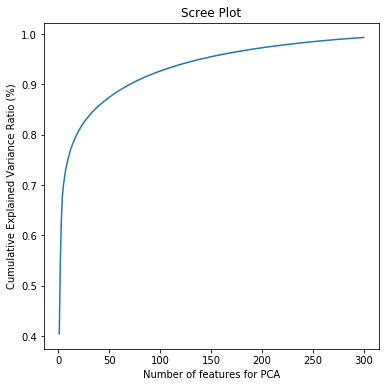

In [1142]:
numfeatures = list(range(1,n+1))
plt.figure(figsize=(6,6))
plt.plot(numfeatures, variance_sum_list)
plt.title('Scree Plot')
plt.ylabel('Cumulative Explained Variance Ratio (%)')
plt.xlabel('Number of features for PCA')

To get 95% explained variance, we select 141 Principal components.

In [1144]:
from sklearn.decomposition import PCA
n = 141
pca = PCA(n_components = n, random_state = 0)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X))

In [1145]:
print('The number of explained variance when n={} is {}' .format(n, sum(pca.explained_variance_ratio_)))

The number of explained variance when n=141 is 0.9504128486643891


# Model Training

Creating a helper function `kfold_train_test_split` to split dataset into train/Cross-validation set with a split of 90:10. 

In [906]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils.testing import ignore_warnings
@ignore_warnings(category=ConvergenceWarning)

def kfold_train_test_split(data, target):
    """
    Create k-fold validation set train-test split in the ratio of 90:10.
    """
    X_traincv, X_test, y_traincv, y_test = train_test_split(data, target, test_size=0.1, random_state=42)
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    for train_index, test_index in kf.split(X_traincv):
        X_train, X_cv = X_traincv.iloc[train_index], X_traincv.iloc[test_index]
        y_train, y_cv = y_traincv.iloc[train_index], y_traincv.iloc[test_index]
    return X_train, X_cv, y_train, y_cv

In [1146]:
X_train, X_cv, y_train, y_cv = kfold_train_test_split(X_pca, y_pca)

Next, we create helper functions 
* `score` that helps with getting the F1 score.
* `KNearestNeighbor` that helps with selecting k in KNN classifier.
* `SVC` that helps with selecting the best C (regularizing parameter) for SVC.
* `LSVC` that helps with selecting the best C (regularizing parameter) for Linear SVC.

In [908]:
from sklearn.metrics import f1_score, accuracy_score
def score(Classifier, X_testset, y_testset, option):
    y_pred = Classifier.predict(X_testset)
    if option == 'f1': 
        score =  f1_score(y_testset, y_pred, average='macro')
        print ("F1-Score on CV set is {}" .format(round(score,4)))
    elif option == 'accuracy':
        score =  accuracy_score(y_testset, y_pred)
        print ("Accuracy Score on CV set is {}" .format(round(score,4)))
    return score

In [715]:
from sklearn.neighbors import KNeighborsClassifier
@ignore_warnings(category=ConvergenceWarning)
def KNearestNeighbor():
    """
    Use KNearestNeighbor('f1') or KNearestNeighbor('accuracy')
    to print the F1- or accuracy scores for different k on the 
    training set.
    """
    print ("For KNN:")
    for i in [1,2,3,4,5,6,7,8,9,10,100,200,300]:
        print ("\nWhen k = {}". format(i))
        KNN = KNeighborsClassifier(i)
        KNN.fit(X_train, y_train)
        y_pred = KNN.predict(X_cv)
        print("F1 score is {}" .format(round(f1_score(y_cv, y_pred, average='macro'),4)))


In [1148]:
import sklearn
def SVC():
    """
    Use KNearestNeighbor('f1') or KNearestNeighbor('accuracy')
    to print the F1- or accuracy scores for different k on the 
    training set.
    """
    print ("For KNN:")
    for i in [0.01,0.1,1,2,3,4,5,6,7,8]:
        print ("\nWhen C = {}". format(i))
        svc = sklearn.svm.SVC(C=i, random_state=0, class_weight = 'balanced', gamma='scale')
        svc.fit(X_train, y_train.values.ravel())
        y_pred = svc.predict(X_cv)
        print(f1_score(y_cv, y_pred, average='macro'))

In [ ]:
from sklearn.svm import LinearSVC
def LSVC():
    """
    Use KNearestNeighbor('f1') or KNearestNeighbor('accuracy')
    to print the F1- or accuracy scores for different k on the 
    training set.
    """
    print ("For KNN:")
    for i in [1,2,3,4,5,6,7,8,9,10,100,200,300]:
        print ("\nWhen C = {}". format(i))
        svc = LinearSVC(C=i, random_state=0, class_weight = 'balanced', dual = False, max_iter = 1000)
        svc.fit(X_train, y_train.values.ravel())
        y_pred = svc.predict(X_cv)
        print(f1_score(y_cv, y_pred, average='macro'))

In [1153]:
y_pred = KNearestNeighbor()

For KNN:

When k = 1
F1 score is 0.7884

When k = 2
F1 score is 0.7655

When k = 3
F1 score is 0.7744

When k = 4
F1 score is 0.7725

When k = 5
F1 score is 0.7738

When k = 6
F1 score is 0.7749

When k = 7
F1 score is 0.77

When k = 8
F1 score is 0.7678

When k = 9
F1 score is 0.7687

When k = 10
F1 score is 0.7686

When k = 100
F1 score is 0.7255

When k = 200
F1 score is 0.6974

When k = 300
F1 score is 0.6741


In [1149]:
y_pred_svc = SVC('f1') #for unsliced data.

For KNN:

When C = 0.01
0.6900847019960317

When C = 0.1
0.7510276100330563

When C = 1
0.8113783760811286

When C = 2
0.8228178959321504

When C = 3
0.8245816715984832

When C = 4
0.8252904465720043

When C = 5
0.8240449127902953

When C = 6
0.8257122777840301

When C = 7
0.8264519595848178

When C = 8
0.8260572950417929


In [1152]:
LSVC('f1')

For KNN:

When C = 1
0.7353244216632312

When C = 2
0.7361894063252671

When C = 3
0.7366399141464308

When C = 4
0.7369660507705373

When C = 5
0.7369660507705373

When C = 6
0.7369660507705373

When C = 7
0.7366883369989897

When C = 8
0.7369660507705373

When C = 9
0.7373950832714221

When C = 10
0.737862520400969

When C = 100
0.735948427688756

When C = 200
0.735948427688756

When C = 300
0.735948427688756


### Model Training: Selecting SVC with C=7

Here, we use k-nearest neighbor classifier. To decide on the number of neighbours, we train the classifier on the training set and select the classifier with the highest F1-Score on the cross validation set. From these results, we see that the F1-score is the highest when k=1. This is not surprising since the data is not very separable.

Calculating the naive predictor's F1-score as a baseline to compare the model's F1-score.

In [1019]:
y_naive = ['MRT'] * len(y_cv)
score =  f1_score(y_cv, y_naive, average='macro')
#score =  accuracy_score(y_cv, y_naive)
score

C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.10680920288171043

We select the n=8 for KNN and C=8 for SVC.  

Then we predict the results on the cross validation set (a test set, ideally).

In [1150]:
SVC = sklearn.svm.SVC(C=7, random_state=0, class_weight = 'balanced', gamma='scale')
SVC.fit(X_train, y_train.values.ravel())
y_pred = SVC.predict(X_cv)

To analyse the results further, let's plot the confusion matrix.

In [1021]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title='Normalized confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
   # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
 
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.73 0.05 0.19 0.   0.02]
 [0.03 0.71 0.24 0.   0.02]
 [0.09 0.1  0.8  0.   0.01]
 [0.   0.01 0.01 0.97 0.01]
 [0.01 0.01 0.05 0.   0.93]]


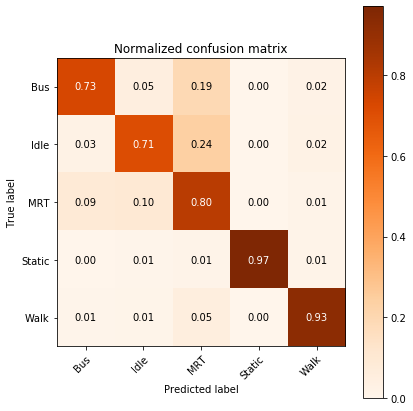

In [1151]:
plot_confusion_matrix(y_cv, y_pred, classes = ['Bus', 'Idle', 'MRT', 'Static', 'Walk'], normalize = True)

The model performed pretty well! However, we note that the model could be improved for bus/idle/mrt. Moreover, the model could be overfitted.

### Conclusion
#### The Good:
* The model presented is useful in separating different modes of transport.

#### The Bad:
* No data from other phones/users/car journeys are collected.

#### Next steps:
* Investigate the effect of sampling rate on superior model. 
* Collect data for car journeys & other users.
* Select less features.

In this notebook, the steps outlined in 'Towards Clustering of Mobile and Smartwatch Accelerometer Data for Physical Activity Recognition' by Chelsea Dobbins are followed to achieve clustering of acceleratometer. A set of slides that complement this notebook is uploaded [here](https://drive.google.com/drive/u/0/folders/1H1vtK-EHlr6vijiMOqqy_z2hAle5REEX). 